In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -ltr /content/drive/MyDrive/educative_natural_language_processing_for_professionals/models

total 0


## Gather Data

In [ ]:
import urllib.request as req
from urllib.parse import urlparse
import os
import progressbar
import zipfile
import gzip
import shutil
import json
import pandas as pd
import re
import string
import imblearn

pbar = None


def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = progressbar.ProgressBar(maxval=total_size)
        pbar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

def wget(url):
    a = urlparse(url)
    filename = os.path.basename(a.path)
    if not os.path.isfile(filename):
        req.urlretrieve(url, filename, show_progress)
        print(f'downloaded to {filename}')
    else:
        print(f'file {filename} has already been downloaded')
    return filename

def unzip(filename, directory_to_extract_to=os.getcwd()):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)
        print(f'extraction done {zip_ref.namelist()}')

def gunzip(gzfile, fout):
    with gzip.open(gzfile, 'rb') as f_in:
        with open(fout, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f'{gzfile} extracted to {fout}')


# map punctuation to space
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) 

def text_preprocessing(text):
    """
    Preprocess the text for better understanding
    
    """
    text = text.strip()
    text = text.lower()
    text = text.translate(translator)
    return text


filename = wget("https://nlp.stanford.edu/data/glove.6B.zip")
unzip(filename)
Video_Games_5 = wget('http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz')
df = pd.read_json("./Video_Games_5.json.gz", lines=True, compression='gzip')
df = df[['reviewText', 'overall']]
df = df.dropna()
df['reviewText'] = df['reviewText'].apply(text_preprocessing)
df = df.drop_duplicates()
print(df.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
100% (862182613 of 862182613) |##########| Elapsed Time: 0:02:41 Time:  0:02:41


downloaded to glove.6B.zip
extraction done ['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt']


100% (154050105 of 154050105) |##########| Elapsed Time: 0:00:08 Time:  0:00:08


downloaded to Video_Games_5.json.gz
(399899, 2)


In [ ]:
df.sample(10)

,reviewText,overall
384482,heavy weight dedede is one of the largest amii...,5
249594,love the updates from the previous version ac...,5
266625,great game 100 recommended,5
58589,as an annual purchaser some may say sucker o...,4
387276,i was honestly disappointed with this halo ins...,3
283158,fits the wii u perfectly and protects it,5
204061,i had fun playing the previous 2 gears of war ...,4
107053,i ve played all of her interactive s nancy dre...,3
396176,my son loves it and recommend this game to eve...,5
122504,great product,4


## Split train and test

In [ ]:
from sklearn.model_selection import train_test_split

sentences = df['reviewText'].values
y = df['overall'].values
y = pd.get_dummies(y).values

sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.3, random_state=42, stratify=df.overall)

print(len(sentences_train), len(sentences_test))

279929 119970


## Input Tensors

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 316   12   80  236 2964  319  269    2  299    5   25   13 1136   78
 1039    4  165 2517   19    1  166 1718    5   58  204    1 3145  156
    6    9   23   29  298  294   11  366   57   16   49   78  156    6
   46   23  861   57    3  935   19    1    6 1713   52   41  309    1
 1339  875 1463 4658   61   24   27   51  530   19  251  202    5  219
  221   11  599  156    6    9    1   99 3429   14    1 3602  296   28
    8   21   23  433   11  388    5   26    6   86   13 3279   34  582
   11 1112]


## Embedding Matrix

Mapping of words in the corpus with the glove embeddings

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    './glove.6B.50d.txt', tokenizer.word_index, embedding_dim)

## Compute class weights

In [ ]:
from sklearn.utils import compute_class_weight

y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

## helper functions

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Shallow Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam

maxlen = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.Dropout(0.2))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           7776850   
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                        

In [ ]:
batch_size = 64
epochs = 100

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, epochs=epochs, 
                    class_weight=d_class_weights, shuffle=True,
                    verbose=1, validation_split=0.1)

Epoch 1/100
3937/3937 [==============================] - 20s 4ms/step - loss: 1.5319 - accuracy: 0.4144 - val_loss: 1.4586 - val_accuracy: 0.4205
Epoch 2/100
3937/3937 [==============================] - 17s 4ms/step - loss: 1.5045 - accuracy: 0.4100 - val_loss: 1.4243 - val_accuracy: 0.4303
Epoch 3/100
3937/3937 [==============================] - 17s 4ms/step - loss: 1.4971 - accuracy: 0.4019 - val_loss: 1.4048 - val_accuracy: 0.4343
Epoch 4/100
3937/3937 [==============================] - 17s 4ms/step - loss: 1.4931 - accuracy: 0.4005 - val_loss: 1.3961 - val_accuracy: 0.4442
Epoch 5/100
3937/3937 [==============================] - 18s 4ms/step - loss: 1.4914 - accuracy: 0.4007 - val_loss: 1.3702 - val_accuracy: 0.4652
Epoch 6/100
3937/3937 [==============================] - 17s 4ms/step - loss: 1.4894 - accuracy: 0.4001 - val_loss: 1.3677 - val_accuracy: 0.4541
Epoch 7/100
3937/3937 [==============================] - 17s 4ms/step - loss: 1.4870 - accuracy: 0.3994 - val_loss: 1.3266 -

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

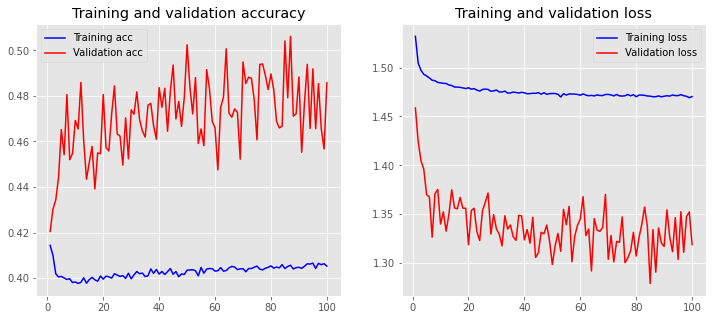

In [ ]:
plot_history(history)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.4857
Testing Accuracy:  0.4831


In [ ]:
import string

# # map punctuation to space
# translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) 

# def text_preprocessing(text):
#     """
#     Preprocess the text for better understanding
    
#     """
#     text = text.strip()
#     text = text.lower()
#     text = text.translate(translator)
#     return text

def predict(text, model, tokenizer):
    orig_text = text
    text = text_preprocessing(text)
    text = [text]
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=maxlen)
    # print(np.sum(model.predict(X)[0]))
    probs = model.predict(X)[0]
    # assert np.sum(probs) == 1.0
    prediction = np.argmax(probs)
    print('input text: ', orig_text)
    print('predicted class: ', prediction + 1, 'confidence:', np.max(probs))


predict('I liked the product quite a lot.', model, tokenizer)
predict('playing this was the worst time in my life.', model, tokenizer)

input text:  I liked the product quite a lot.
predicted class:  5 confidence: 0.32568368
input text:  playing this was the worst time in my life.
predicted class:  5 confidence: 0.382311


In [ ]:
from sklearn.metrics import accuracy_score, matthews_corrcoef
from imblearn.metrics import classification_report_imbalanced

y_pred = model.predict(X_test)

print('accuracy:', accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print('matthews_corrcoef:', matthews_corrcoef(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print('classification_report:\n', classification_report_imbalanced(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


accuracy: 0.48311244477786114
matthews_corrcoef: 0.2248240429789915
classification_report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.24      0.53      0.87      0.33      0.68      0.45      8380
          1       0.13      0.24      0.91      0.17      0.47      0.20      6711
          2       0.23      0.14      0.94      0.17      0.36      0.12     13254
          3       0.32      0.29      0.84      0.30      0.49      0.23     24551
          4       0.73      0.64      0.70      0.68      0.67      0.45     67074

avg / total       0.52      0.48      0.78      0.50      0.59      0.35    119970



### Plot of model metrics

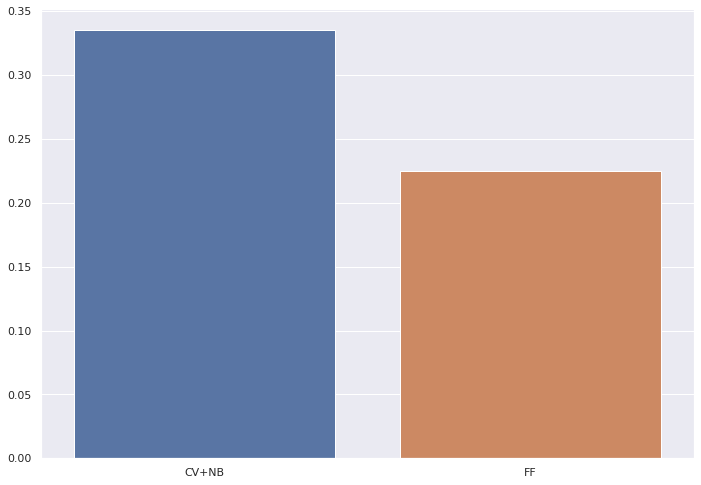

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

# data
x = ["CV+NB",             "FF"]
y = [0.33504969057289086, 0.2248240429789915]

ax = sns.barplot(x=x, y=y)

## Convolutional Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras import layers

tf.random.set_seed(42)


model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model.add(layers.Conv1D(128, 3, activation='relu'))
# TODO try by using batch normalisation as well
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           7776850   
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 128)           19328     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 7,800,471
Trainable params: 23,621
Non-trainable params: 7,776,850
_______________________________________

### training the base CNN model

In [ ]:
batch_size = 64
epochs = 100

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, epochs=epochs, 
                    class_weight=d_class_weights, shuffle=True,
                    verbose=1, validation_split=0.1)

Epoch 1/100
3937/3937 [==============================] - 56s 7ms/step - loss: 1.3169 - accuracy: 0.4855 - val_loss: 1.2510 - val_accuracy: 0.4790
Epoch 2/100
3937/3937 [==============================] - 27s 7ms/step - loss: 1.2237 - accuracy: 0.5320 - val_loss: 1.0058 - val_accuracy: 0.5895
Epoch 3/100
3937/3937 [==============================] - 28s 7ms/step - loss: 1.1927 - accuracy: 0.5440 - val_loss: 1.2201 - val_accuracy: 0.4892
Epoch 4/100
3937/3937 [==============================] - 28s 7ms/step - loss: 1.1729 - accuracy: 0.5510 - val_loss: 1.0335 - val_accuracy: 0.5748
Epoch 5/100
3937/3937 [==============================] - 28s 7ms/step - loss: 1.1592 - accuracy: 0.5527 - val_loss: 1.0417 - val_accuracy: 0.5812
Epoch 6/100
3937/3937 [==============================] - 26s 7ms/step - loss: 1.1464 - accuracy: 0.5562 - val_loss: 1.0827 - val_accuracy: 0.5616
Epoch 7/100
3937/3937 [==============================] - 28s 7ms/step - loss: 1.1363 - accuracy: 0.5600 - val_loss: 1.0679 -

### plot training statistics

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

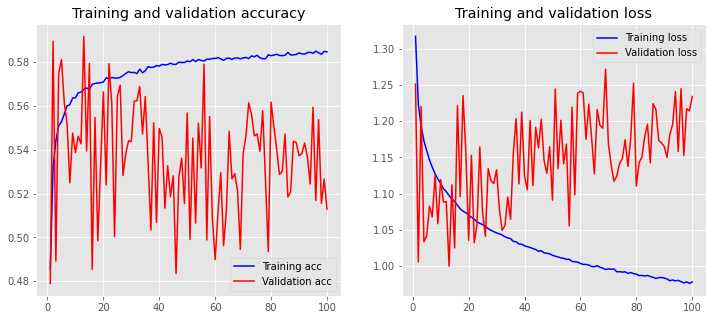

In [ ]:
plot_history(history)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5687
Testing Accuracy:  0.5120


### predict function for the trigram model

In [ ]:
import string

def predict(text, model, tokenizer):
    orig_text = text
    text = text_preprocessing(text)
    text = [text]
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=maxlen)
    # print(np.sum(model.predict(X)[0]))
    probs = model.predict(X)[0]
    # assert np.sum(probs) == 1.0
    prediction = np.argmax(probs)
    print('input text: ', orig_text)
    print('predicted class: ', prediction + 1, 'confidence:', np.max(probs))

In [ ]:
predict('I liked the product quite a lot.', model, tokenizer)
predict('playing this was the worst time in my life.', model, tokenizer)

input text:  I liked the product quite a lot.
predicted class:  4 confidence: 0.51011616
input text:  playing this was the worst time in my life.
predicted class:  1 confidence: 0.37797365


### metrics for the trigram model

In [ ]:
from sklearn.metrics import accuracy_score, matthews_corrcoef
from imblearn.metrics import classification_report_imbalanced

y_pred = model.predict(X_test)

print('accuracy:', accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print('matthews_corrcoef:', matthews_corrcoef(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print('classification_report:\n', classification_report_imbalanced(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

accuracy: 0.5120030007501876
matthews_corrcoef: 0.3120980983604428
classification_report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.44      0.46      0.96      0.45      0.67      0.42      8380
          1       0.20      0.42      0.90      0.27      0.61      0.36      6711
          2       0.27      0.36      0.88      0.31      0.56      0.30     13254
          3       0.34      0.45      0.77      0.38      0.59      0.34     24551
          4       0.84      0.58      0.86      0.69      0.71      0.48     67074

avg / total       0.61      0.51      0.85      0.54      0.66      0.42    119970



### plot of model metrics till now

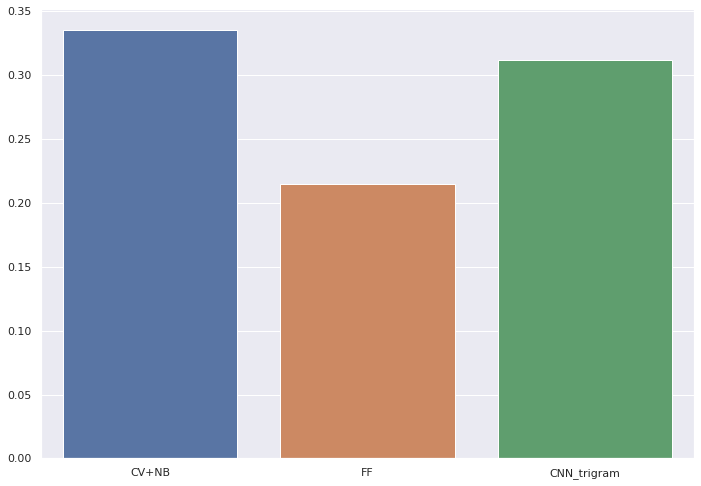

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

# data
x = ["CV+NB",             "FF",               "CNN_trigram"]
y = [0.33504969057289086, 0.2148927270393169, 0.3120980983604428]

ax = sns.barplot(x=x, y=y)

### save the trigram model

In [ ]:
trigram_model_path = "/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/cnn_trigram_model"
model.save(trigram_model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/cnn_trigram_model/assets


## CNN234GramModel

some bigrams such as "Final Fantasy" is a strong indicator that the reviews are good.

In [ ]:
df[df.reviewText.str.contains("final fantasy")].sample(10)

,reviewText,overall
34349,i ll admit that i didn t think that this game ...,5
414973,brought mine at game stop and its alright if y...,4
18848,most people either say that they hate it or th...,5
366789,for a side story entry in the final fantasy un...,4
18728,shame on anyone who doesn t make this a 5 star...,5
102323,in a nutshell mass effect was not only worth ...,5
56854,this is ione great game you don t necessaril...,5
87748,what is this piece of crap terrible cartoonis...,1
366684,i will start with the few flaws and get them o...,4
249740,it s hard to say exactly what is so appealing ...,5


In [ ]:
import string
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, matthews_corrcoef
from imblearn.metrics import classification_report_imbalanced
import matplotlib.pyplot as plt
plt.style.use('ggplot')


# map punctuation to space
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) 

def text_preprocessing(text):
    """
    Preprocess the text for better understanding
    
    """
    text = text.strip()
    text = text.lower()
    text = text.translate(translator)
    return text

def predict(text, model, tokenizer):
    orig_text = text
    text = text_preprocessing(text)
    text = [text]
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=maxlen)
    # print(np.sum(model.predict(X)[0]))
    probs = model.predict(X)[0]
    # assert np.sum(probs) == 1.0
    prediction = np.argmax(probs)
    print('input text: ', orig_text)
    print('predicted class: ', prediction + 1, 'confidence:', np.max(probs))

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


class CNN234GramModel(tf.keras.Model):
    def __init__(self, nb_filters=50,
                 FFN_units=512, nb_classes=2, dropout_rate=0.1, name="dcnn"):
        super(CNN234GramModel, self).__init__(name=name)
        self.embedding = layers.Embedding(vocab_size, embedding_dim,
                                          input_length=maxlen,
                                          weights=[embedding_matrix],
                                          trainable=False)

        self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2,
                                    padding="valid", activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3,
                                    padding="valid", activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4,
                                    padding="valid", activation="relu")
        self.pool1 = layers.GlobalMaxPooling1D()
        self.pool2 = layers.GlobalMaxPooling1D()
        self.pool3 = layers.GlobalMaxPooling1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1, activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes, activation="softmax")

    def call(self, inputs, training):
        embs = self.embedding(inputs)
        x_1 = self.bigram(embs)
        x_1 = self.pool1(x_1)
        x_2 = self.trigram(embs)
        x_2 = self.pool2(x_2)
        x_3 = self.fourgram(embs)
        x_3 = self.pool3(x_3)
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3*nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)

        return output

    # AFAIK: The most convenient method to print model.summary() 
    # similar to the sequential or functional API like.
    def build_graph(self, input_shape):
        x = Input(shape=input_shape)
        return tf.keras.Model(inputs=[x], outputs=self.call(x, False))

NB_FILTER = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.2

batch_size = 64
epochs = 100



dcnn = CNN234GramModel(nb_filters=NB_FILTER,
            FFN_units=FFN_UNITS, nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam", metrics=["accuracy"])
else:
    dcnn.compile(loss="categorical_crossentropy", optimizer="adam",
                 metrics=["accuracy"])
  
def training(model):
    history = model.fit(X_train, y_train, 
                        batch_size=batch_size, epochs=epochs, 
                        class_weight=d_class_weights, shuffle=True,
                        verbose=1, validation_split=0.1)

    plot_history(history)

    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))

    predict('I liked the product quite a lot.', model, tokenizer)
    predict('playing this was the worst time in my life.', model, tokenizer)

    y_pred = model.predict(X_test)

    print('accuracy:', accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
    print('matthews_corrcoef:', matthews_corrcoef(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
    print('classification_report:\n', classification_report_imbalanced(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

In [ ]:
input_shape = [batch_size, 100]
dcnn.build(input_shape)
# dcnn.build_graph(input_shape).summary()
dcnn.summary()

Model: "dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 64, 100, 50)       7776850   
                                                                 
 conv1d_17 (Conv1D)          (None, 64, 99, 100)       10100     
                                                                 
 conv1d_18 (Conv1D)          (None, 64, 98, 100)       15100     
                                                                 
 conv1d_19 (Conv1D)          (None, 64, 97, 100)       20100     
                                                                 
 global_max_pooling1d_7 (Glo  multiple                 0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            multiple                  77056     
                                                              

### training the v1 model

Epoch 1/100
3937/3937 [==============================] - 37s 9ms/step - loss: 1.3273 - accuracy: 0.4868 - val_loss: 1.1941 - val_accuracy: 0.5049
Epoch 2/100
3937/3937 [==============================] - 34s 9ms/step - loss: 1.2210 - accuracy: 0.5355 - val_loss: 1.1196 - val_accuracy: 0.5281
Epoch 3/100
3937/3937 [==============================] - 36s 9ms/step - loss: 1.1816 - accuracy: 0.5499 - val_loss: 1.1013 - val_accuracy: 0.5598
Epoch 4/100
3937/3937 [==============================] - 37s 9ms/step - loss: 1.1510 - accuracy: 0.5567 - val_loss: 1.0355 - val_accuracy: 0.5631
Epoch 5/100
3937/3937 [==============================] - 38s 10ms/step - loss: 1.1270 - accuracy: 0.5617 - val_loss: 1.0369 - val_accuracy: 0.5785
Epoch 6/100
3937/3937 [==============================] - 38s 10ms/step - loss: 1.1055 - accuracy: 0.5643 - val_loss: 0.9923 - val_accuracy: 0.5888
Epoch 7/100
3937/3937 [==============================] - 38s 10ms/step - loss: 1.0837 - accuracy: 0.5691 - val_loss: 1.034

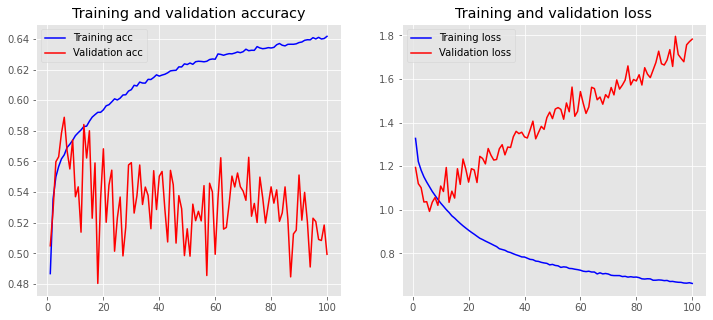

In [ ]:
training(dcnn)

### plot of model metrics till now

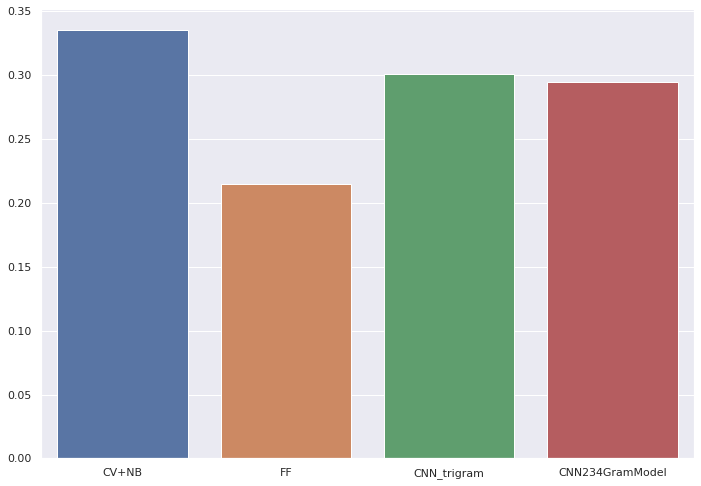

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

# data
x = ["CV+NB",             "FF",               "CNN_trigram",      "CNN234GramModel"]
y = [0.33504969057289086, 0.2148927270393169, 0.3006712012400788, 0.29459743828288504]

ax = sns.barplot(x=x, y=y)

### save the 234-CNN model

In [ ]:
cnn_234gram_model_path = "/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/cnn_234gram_model"
dcnn.save(cnn_234gram_model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/cnn_234gram_model/assets


## CNN234GramModel with batch norm

In [ ]:
import string
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
plt.style.use('ggplot')


# map punctuation to space
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) 

def text_preprocessing(text):
    """
    Preprocess the text for better understanding
    
    """
    text = text.strip()
    text = text.lower()
    text = text.translate(translator)
    return text

def predict(text, model, tokenizer):
    orig_text = text
    text = text_preprocessing(text)
    text = [text]
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=maxlen)
    # print(np.sum(model.predict(X)[0]))
    probs = model.predict(X)[0]
    # assert np.sum(probs) == 1.0
    prediction = np.argmax(probs)
    print('input text: ', orig_text)
    print('predicted class: ', prediction + 1, 'confidence:', np.max(probs))


def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    

class CNN234GramModel1(tf.keras.Model):
    def __init__(self, nb_filters=50,
                 FFN_units=512, nb_classes=2, dropout_rate=0.1, name="dcnn"):
        super(CNN234GramModel1, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size, embedding_dim,
                                        input_length=maxlen,
                                        weights=[embedding_matrix],
                                        trainable=False)

        self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding="valid")
        self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding="valid")
        self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding="valid")
        self.batchnorm = layers.BatchNormalization()
        self.activation = layers.Activation('relu')
        self.pool1 = layers.GlobalMaxPooling1D()
        self.pool2 = layers.GlobalMaxPooling1D()
        self.pool3 = layers.GlobalMaxPooling1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
        self.last_dense = layers.Dense(units=1, activation="sigmoid")
        else:
        self.last_dense = layers.Dense(units=nb_classes, activation="softmax")
        
    def convolv(self, ngram, embs):
        x = ngram(embs)
        x = self.batchnorm(x)
        x = self.activation(x)
        x = self.pool(x)
        return x
        
    def call(self, inputs, training):
        embs = self.embedding(inputs)
        x_1 = self.convolv(self.bigram, embs)
        x_2 = self.convolv(self.trigram, embs)
        x_3 = self.convolv(self.fourgram, embs)
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3*nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)

        return output

NB_FILTER = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.2

NB_EPOCHS = 5



dcnn_v2 = CNN234GramModel1(nb_filters=NB_FILTER, FFN_units=FFN_UNITS, 
                           nb_classes=NB_CLASSES, dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    dcnn_v2.compile(loss="binary_crossentropy",
                    optimizer="adam", metrics=["accuracy"])
else:
    dcnn_v2.compile(loss="categorical_crossentropy", optimizer="adam",
                    metrics=["accuracy"])

### training the v2 model

Epoch 1/100
3937/3937 [==============================] - 49s 12ms/step - loss: 1.3550 - accuracy: 0.4717 - val_loss: 1.2788 - val_accuracy: 0.4255
Epoch 2/100
3937/3937 [==============================] - 47s 12ms/step - loss: 1.2455 - accuracy: 0.5226 - val_loss: 1.1118 - val_accuracy: 0.5394
Epoch 3/100
3937/3937 [==============================] - 46s 12ms/step - loss: 1.2100 - accuracy: 0.5354 - val_loss: 1.2075 - val_accuracy: 0.4927
Epoch 4/100
3937/3937 [==============================] - 47s 12ms/step - loss: 1.1798 - accuracy: 0.5456 - val_loss: 1.1038 - val_accuracy: 0.5188
Epoch 5/100
3937/3937 [==============================] - 47s 12ms/step - loss: 1.1579 - accuracy: 0.5492 - val_loss: 1.0706 - val_accuracy: 0.5541
Epoch 6/100
3937/3937 [==============================] - 48s 12ms/step - loss: 1.1366 - accuracy: 0.5539 - val_loss: 1.0378 - val_accuracy: 0.5835
Epoch 7/100
3937/3937 [==============================] - 47s 12ms/step - loss: 1.1202 - accuracy: 0.5576 - val_loss: 1

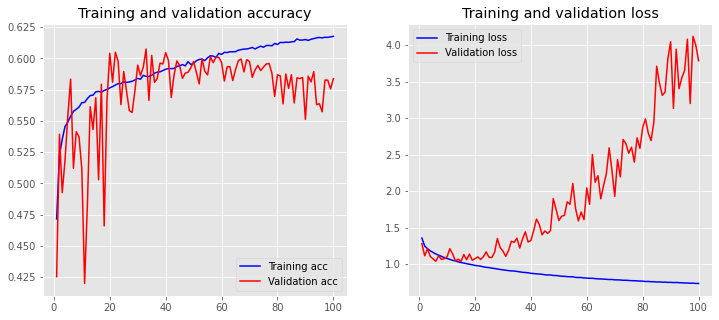

In [ ]:
training(dcnn_v2)

### plot the model metrics till now

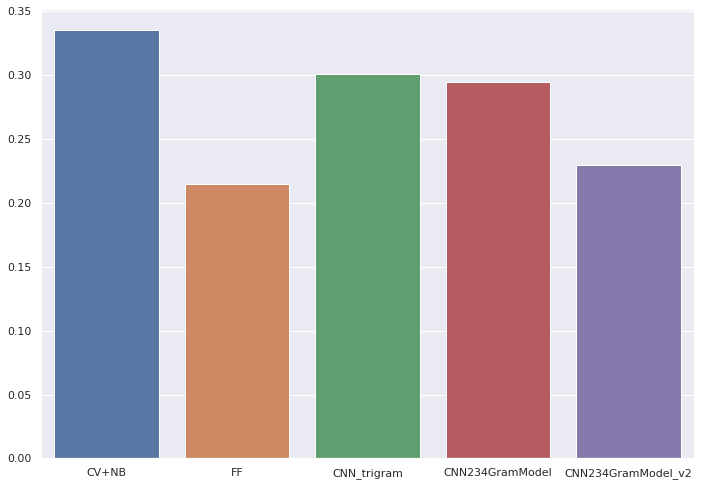

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

# data
x = ["CV+NB",             "FF",               "CNN_trigram",      "CNN234GramModel",   "CNN234GramModel_v2"]
y = [0.33504969057289086, 0.2148927270393169, 0.3006712012400788, 0.29459743828288504, 0.22974056487796335]

ax = sns.barplot(x=x, y=y)

### save the CNN v2 model

In [ ]:
cnn_234gram_modelv2_path = "/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/cnn_234gram_modelv2"
dcnn_v2.save(cnn_234gram_modelv2_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/cnn_234gram_modelv2/assets
